# Submission

- model ensembel CE model 
 1. street view 
 2. top view

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- all infos
inference_dict ={
    'models':[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_5.yaml', 'finetune_8.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('./configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    inference_dict['cfgs'].append(cfg)
    print("Model run version : ", cfg.RUN_VERSION)

Model run version :  15
Model run version :  18


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [5]:
ckpt_paths = [
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/15_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.65_epoch_8.pth",
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/18_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.7226_epoch_5.pth" ]

for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i]))

In [6]:
train_set = map_dataset.Map_Dataset_v7(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v7(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

idx :  787


3 < Label > 
3 < 1 Model Prediction > 
tensor([[4.3015e-05, 3.1106e-05, 1.9087e-04, 9.9497e-01, 4.7418e-03, 1.6124e-05,
         8.1772e-06]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


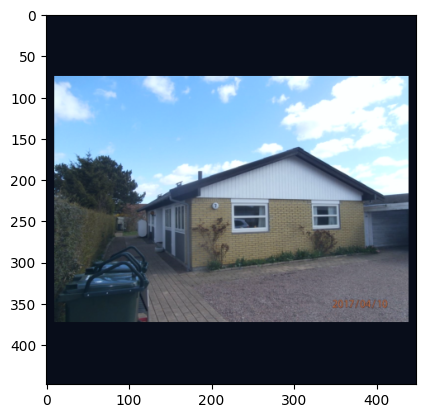

In [7]:
'''
#--- Single image for Visualization 
# A model : Cross-entropy loss with Street Voew 
# B model : Cross-entropy loss with Top Voew

'''
idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
img_torch = street_view 
#RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"


def infer_model(img_torch,model,loss_type):
    
    img_torch = img_torch.to(device)
    
    model = model.eval()
    model = model.to(device)
    img_torch = img_torch.unsqueeze(0)
    preds = model(img_torch)
    
    if loss_type == "CE":
        preds_ = preds.softmax(-1).argmax(-1)
    elif loss_type == "MSE" or loss_type == "MAE":
        preds_ = preds
    print(dataset.__getitem__(idx_)[-1], "< Label > ")
    print(preds_.item(), f"< {i} Model Prediction > ")
    #print(preds)
    print(preds.softmax(-1))
    
    img_torch = img_torch.squeeze(0)
    img = img_torch.clone() 
    
    # denormal
    img = ((img) * 0.22) + 0.5
    # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    #-----
            
    img = img.permute(1,2,0).cpu()
    img = np.asarray(img)   
    plt.imshow(img)
        
            
#-- 
infer_model(img_torch,inference_dict['models'][0],"CE")

3 < Label > 
3 < 1 Model Prediction > 
tensor([[0.0012, 0.0036, 0.0351, 0.6290, 0.0666, 0.0224, 0.2421]],
       device='cuda:3', grad_fn=<SoftmaxBackward0>)


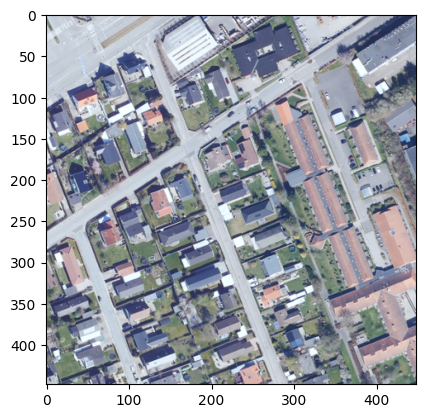

In [8]:
top_view = dataset.__getitem__(idx_)[1]
img_torch = top_view 

infer_model(img_torch,inference_dict['models'][1],"CE")

# Test

In [9]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_test = os.listdir(test_path)
names_test = sorted(names_test)

In [10]:
submit_df = pd.DataFrame(
    {"idx":[i for i in range(len(names_test))],
     "names_test":names_test,
     "street_veiw_exists":[False for i in range(len(names_test))],
     "street_view_prediction" :[0 for i in range(len(names_test))],
     "top_view_prediction" : [0 for i in range(len(names_test))]}
)

In [11]:
submit_df.head()

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,False,0,0
1,1,22pujdqtiu,False,0,0
2,2,23ykackznc,False,0,0
3,3,2435ikdnmf,False,0,0
4,4,24akvvheae,False,0,0


In [12]:
for ID in names_test:
    street_file_ = os.path.join( test_path + ID + '/street.jpg')
    if os.path.exists(street_file_):
        submit_df.loc[submit_df['names_test'] == ID, 'street_veiw_exists'] = True
        

In [13]:
submit_df.head()

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,0,0
1,1,22pujdqtiu,True,0,0
2,2,23ykackznc,False,0,0
3,3,2435ikdnmf,True,0,0
4,4,24akvvheae,False,0,0


In [14]:
street_view_names = submit_df.loc[submit_df['street_veiw_exists'] == True, 'names_test']
street_view_names = sorted(street_view_names)

In [15]:
len(street_view_names)

2167

In [16]:
test_set = map_dataset.Map_Dataset_v7(street_view_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test") 

In [17]:
'''
gather predictions of CE model 1

'''

model = inference_dict['models'][0]


from tqdm import tqdm 

batch_size = 1
TestLoader = DataLoader(test_set,batch_size,shuffle=False)

device = "cuda:3"

#-- Loader train/valid
Loader = TestLoader
#--
#labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    #lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    #labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
#inference_dict['labels'].append(labels_)


100%|██████████| 2167/2167 [01:30<00:00, 23.95it/s]


In [18]:
# A = {
#     "tensors" : [ i.softmax(-1) for i in predictions_]
# }

In [19]:
# for name, pred in zip(street_view_names,predictions_):
#     print(name,pred)
#     submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction'] = -1 

In [20]:
submit_df

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,0,0
1,1,22pujdqtiu,True,0,0
2,2,23ykackznc,False,0,0
3,3,2435ikdnmf,True,0,0
4,4,24akvvheae,False,0,0
...,...,...,...,...,...
4524,4524,zz33egthkw,False,0,0
4525,4525,zzfq447gpt,False,0,0
4526,4526,zzijnoebwv,True,0,0
4527,4527,zzphni4qma,True,0,0


In [21]:
len(street_view_names),len(predictions_)

(2167, 2167)

In [22]:
len(names_test)

4529

In [24]:
'''
gather predictions of CE model 2 

'''
test_set = map_dataset.Map_Dataset_v7(names_test,test_path,max_size=data_config['input_size'][1],cfg=cfg,
                                      split="test",test_mode="top_view_only") 
batch_size = 1
TestLoader = DataLoader(test_set,batch_size,shuffle=False)
Loader = TestLoader

model = inference_dict['models'][1]

#--
#labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[1].to(device)
    #lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    #labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
#inference_dict['labels'].append(labels_)

100%|██████████| 4529/4529 [02:48<00:00, 26.85it/s]


In [34]:
street_view_names.__len__(), names_test.__len__()

(2167, 4529)

In [37]:
ce_model_confidence_0 = [max(i.softmax(-1)) for i in inference_dict['predictions'][0]]
print(len(ce_model_confidence_0))

2167


In [38]:
ce_model_confidence_1 = [max(i.softmax(-1)) for i in inference_dict['predictions'][1]]
print(len(ce_model_confidence_1))

4529


In [42]:
ce_model_confidence_0_re = []
cnt = 0
for name in names_test:
    if name in street_view_names:
        score = ce_model_confidence_0[cnt]
        cnt += 1
        ce_model_confidence_0_re.append(score)
    else:
        ce_model_confidence_0_re.append(torch.tensor(0))

In [44]:
ce_model_confidence_0_re

[tensor(0.4381),
 tensor(0.6421),
 tensor(0),
 tensor(0.8449),
 tensor(0),
 tensor(0.9934),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0.9964),
 tensor(0.9732),
 tensor(0.9391),
 tensor(0),
 tensor(0),
 tensor(0.9751),
 tensor(0.9920),
 tensor(0.9989),
 tensor(0),
 tensor(0),
 tensor(0.9682),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0.8947),
 tensor(0),
 tensor(0.7547),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0.6194),
 tensor(0.5902),
 tensor(0),
 tensor(0),
 tensor(0.9413),
 tensor(0),
 tensor(0),
 tensor(0.9989),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0.9999),
 tensor(0.8186),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0.8904),
 tensor(0.9805),
 tensor(0),
 tensor(0.9962),
 tensor(0.9484),
 tensor(0),
 tensor(0.8334),
 tensor(0),
 tensor(0),
 tensor(0.6866),
 tensor(0),
 tensor(0.9999),
 tensor(0),
 tensor(0.9844),
 tensor(0),
 tensor(0),
 tensor(0),
 

In [45]:
len(ce_model_confidence_0_re)

4529

In [47]:
submit_df["street_view_prediction"] = ce_model_confidence_0_re

In [48]:
submit_df

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,tensor(0.4381),0
1,1,22pujdqtiu,True,tensor(0.6421),0
2,2,23ykackznc,False,tensor(0),0
3,3,2435ikdnmf,True,tensor(0.8449),0
4,4,24akvvheae,False,tensor(0),0
...,...,...,...,...,...
4524,4524,zz33egthkw,False,tensor(0),0
4525,4525,zzfq447gpt,False,tensor(0),0
4526,4526,zzijnoebwv,True,tensor(0.9239),0
4527,4527,zzphni4qma,True,tensor(0.6961),0


In [49]:
submit_df['top_view_prediction']= ce_model_confidence_1

In [50]:
submit_df

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,tensor(0.4381),tensor(0.5247)
1,1,22pujdqtiu,True,tensor(0.6421),tensor(0.5235)
2,2,23ykackznc,False,tensor(0),tensor(0.3221)
3,3,2435ikdnmf,True,tensor(0.8449),tensor(0.9699)
4,4,24akvvheae,False,tensor(0),tensor(0.6529)
...,...,...,...,...,...
4524,4524,zz33egthkw,False,tensor(0),tensor(0.6990)
4525,4525,zzfq447gpt,False,tensor(0),tensor(0.7412)
4526,4526,zzijnoebwv,True,tensor(0.9239),tensor(0.5345)
4527,4527,zzphni4qma,True,tensor(0.6961),tensor(0.7784)


In [52]:
idxs_ce_more_confidence = []
cnt = 0
for i, (ce0,ce1) in enumerate( zip(ce_model_confidence_0_re, ce_model_confidence_1) ):
    if ce0 > ce1:
        print(i)
        idxs_ce_more_confidence.append(i)
        cnt += 1

print(f"# of cases ce model 0 more confident : {cnt} / {len(ce_model_confidence_1)}")

1
5
11
12
13
16
17
18
21
26
33
37
40
49
56
58
61
66
68
72
73
74
75
77
83
84
86
88
89
94
98
100
102
105
106
120
121
127
129
130
133
134
135
137
139
140
143
144
148
153
160
163
164
167
168
177
181
185
191
193
196
197
198
200
201
202
205
206
207
209
210
215
218
219
223
225
226
228
235
238
239
240
241
242
248
252
259
260
261
262
263
264
266
267
272
274
275
277
279
282
289
293
294
295
296
303
304
308
310
312
314
315
316
317
318
324
327
328
336
337
338
344
346
347
353
359
360
364
365
366
369
371
372
373
374
381
382
384
387
388
394
396
397
399
401
402
403
405
408
412
421
425
430
431
432
440
441
443
444
445
448
452
453
456
458
460
462
468
470
472
476
478
481
484
485
487
493
497
498
507
509
510
513
514
519
521
526
528
530
532
535
536
537
538
544
546
548
549
551
553
554
559
561
562
568
569
571
572
575
578
580
581
584
586
588
598
601
604
609
610
612
613
615
618
621
624
625
627
628
630
631
633
634
636
637
638
639
641
645
647
652
654
655
657
666
668
669
672
673
674
676
680
681
683
689
690
694
699
7

In [53]:
ensemble_predictions = []

cnt = 0
for idx in range(len(ce_model_confidence_1)):
        
    if idx in idxs_ce_more_confidence:     
        ce_pred_0 = inference_dict['predictions'][0][cnt].softmax(-1).argmax(-1)
        ensemble_predictions.append(ce_pred_0)
        cnt += 1
        print(cnt)
    else:
        ce_pred_1 = inference_dict['predictions'][1][idx].softmax(-1).argmax(-1)
        ensemble_predictions.append(ce_pred_1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [55]:
ensemble_predictions.__len__()

4529

In [76]:
submit_df.head(10)

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,tensor(0.4381),tensor(0.5247)
1,1,22pujdqtiu,True,tensor(0.6421),tensor(0.5235)
2,2,23ykackznc,False,tensor(0),tensor(0.3221)
3,3,2435ikdnmf,True,tensor(0.8449),tensor(0.9699)
4,4,24akvvheae,False,tensor(0),tensor(0.6529)
5,5,24d983q6sy,True,tensor(0.9934),tensor(0.7757)
6,6,24jyazdpcb,False,tensor(0),tensor(0.5660)
7,7,25nnpektbr,False,tensor(0),tensor(0.9238)
8,8,25wtfxzutb,False,tensor(0),tensor(0.8655)
9,9,25xqvcygmf,False,tensor(0),tensor(0.3937)


: 

In [74]:
idxs_ce_more_confidence

[1,
 5,
 11,
 12,
 13,
 16,
 17,
 18,
 21,
 26,
 33,
 37,
 40,
 49,
 56,
 58,
 61,
 66,
 68,
 72,
 73,
 74,
 75,
 77,
 83,
 84,
 86,
 88,
 89,
 94,
 98,
 100,
 102,
 105,
 106,
 120,
 121,
 127,
 129,
 130,
 133,
 134,
 135,
 137,
 139,
 140,
 143,
 144,
 148,
 153,
 160,
 163,
 164,
 167,
 168,
 177,
 181,
 185,
 191,
 193,
 196,
 197,
 198,
 200,
 201,
 202,
 205,
 206,
 207,
 209,
 210,
 215,
 218,
 219,
 223,
 225,
 226,
 228,
 235,
 238,
 239,
 240,
 241,
 242,
 248,
 252,
 259,
 260,
 261,
 262,
 263,
 264,
 266,
 267,
 272,
 274,
 275,
 277,
 279,
 282,
 289,
 293,
 294,
 295,
 296,
 303,
 304,
 308,
 310,
 312,
 314,
 315,
 316,
 317,
 318,
 324,
 327,
 328,
 336,
 337,
 338,
 344,
 346,
 347,
 353,
 359,
 360,
 364,
 365,
 366,
 369,
 371,
 372,
 373,
 374,
 381,
 382,
 384,
 387,
 388,
 394,
 396,
 397,
 399,
 401,
 402,
 403,
 405,
 408,
 412,
 421,
 425,
 430,
 431,
 432,
 440,
 441,
 443,
 444,
 445,
 448,
 452,
 453,
 456,
 458,
 460,
 462,
 468,
 470,
 472,
 476,
 478,
 

In [62]:
df_s = test_df.sort_values(by=["pid"], ascending=[True]) 

In [68]:
df_s['predicted_label'] = [i.numpy() for i in ensemble_predictions]

In [70]:
df_s

,country_id,pid,city_id,predicted_label
3997,QCD,22mhjewvtj,YPGHW,4
2557,QCD,22pujdqtiu,YPGHW,4
1770,FMW,23ykackznc,7PNBD,3
3119,QCD,2435ikdnmf,YPGHW,0
1491,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
2104,FMW,zz33egthkw,7PNBD,0
726,PNN,zzfq447gpt,B2MVH,0
2904,QCD,zzijnoebwv,YPGHW,4
3667,QCD,zzphni4qma,YPGHW,1


In [71]:
submit_name = "ensemble_v1"
df_s.to_csv(f"/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/{submit_name}.csv")